In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [4]:
import os 
os.environ["BASE_MODEL_NAME"] = "InceptionV3"
os.environ["EPOCHS"] = "20"
os.environ["PATIENCE"] = "5"
os.environ["TRAIN_SCALER_PATH"] = "scalers/prediction_model_scaler.pkl"
os.environ["WEIGHT_PATH"] = "models/prediction_model/weights/weights.ckpt"
os.environ["FEATURES_DIMENSIONS"] = "30"
os.environ["MODEL_PATH"] = "models/prediction_model/model"

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import *
from src.train import fit_model
from src.model.model import MyModel
from src.config import prediction_model_config as config
from src.data_preparation.data_generator import DataGenerator
from IPython.display import clear_output
pd.options.mode.chained_assignment = None  

In [6]:
df = load_from_pickle(config.DATA_LOAD_PATH)
df.shape

(7049, 31)

In [7]:
df.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,nose_tip_x,nose_tip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."


Split the dataset into test and train

In [8]:
df_train, df_test = split_data(df[:200])
print(df.shape, df_train.shape, df_test.shape)

(7049, 31) (160, 31) (40, 31)


In [9]:
config.TRAIN_SCALER_PATH

'scalers/prediction_model_scaler.pkl'

### Build train scaler and save it

In [10]:
# fit the MinMaxScaler using the training data and then apply the scaler on the testing data before the prediction.
scaler = create_scaler(df_train.iloc[:,:30],)
save_to_pickle(scaler, config.TRAIN_SCALER_PATH)

### Create train and validation data generators

In [11]:
train_generator = DataGenerator(df_train, 
                                batch_size=config.BATCH_SIZE,
                                augment= config.AUGMENT_TRAIN,
                                rgb_channels= config.RGB_CHANNELS,
                                normalize_image=config.NORMALIZE_IMAGE,
                                normalize_coordinates=config.NORMALIZE_COORDINATES, 
                                scaler=scaler)

val_generator =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_VAL,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

### Create the prediction model

In [12]:
my_model = MyModel(config.IMAGE_SHAPE,
                   config.BASE_MODEL_NAME,
                   config.FEATURES_DIMENSIONS,
                   trainable=config.TRAINABLE,
                   intermediate_dim=config.INTERMEDIATE_DIMENSIONS,
                   dropout_rate=config.DROPOUT_RATE
                  )

In [13]:
my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InceptionV3 (BaseModel)      multiple                  21802784  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
top_model (TopModel)         multiple                  133086    
Total params: 21,935,870
Trainable params: 133,086
Non-trainable params: 21,802,784
_________________________________________________________________


### Train the model

In [14]:
my_model, history = fit_model(my_model, config.EPOCHS, train_generator, val_generator, config.WEIGHT_PATH, config.PATIENCE)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 4.1789
Epoch 00001: val_loss improved from inf to 2.61174, saving model to models/prediction_model/weights/weights.ckpt
5/5 [==============================] - 3s 503ms/step - loss: 4.1789 - val_loss: 2.6117
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 3.4927
Epoch 00002: val_loss improved from 2.61174 to 2.42907, saving model to models/prediction_model/weights/weights.ckpt
5/5 [==============================] - 1s 282ms/step - loss: 3.4927 - val_loss: 2.4291
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 3.0038
Epoch 00003: val_loss did not improve from 2.42907
5/5 [==============================] - 1s 222ms/step - loss: 3.0038 - val_loss: 2.4693
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 2.7811
Epoch 00004: val_loss did not improve from 2.42907
5/5 [==============================] - 1s 220ms/step - loss: 2.7811 - val_loss: 2.5511
Epoch 5/20
5/5 [============

In [16]:
# Recreat the same structure of the model and load its saved weights then build it by predicting a random input then save the model
import tensorflow as tf
from src.train import compile_model
from tensorflow.keras.models import load_model

model = MyModel(config.IMAGE_SHAPE,
                   config.BASE_MODEL_NAME,
                   config.FEATURES_DIMENSIONS,
                   trainable=config.TRAINABLE,
                   intermediate_dim=config.INTERMEDIATE_DIMENSIONS,
                   dropout_rate=config.DROPOUT_RATE
                  )
model.load_weights(config.WEIGHT_PATH)
model.predict(tf.expand_dims(tf.random.uniform(model.image_shape), axis=0))
model.save(config.MODEL_PATH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/prediction_model/model/assets


In [17]:
# load the model to check it
m = load_model(config.MODEL_PATH, compile=False)
m.predict(tf.expand_dims(tf.random.uniform(model.image_shape), axis=0))

array([[0.48540258, 0.        , 0.        , 0.37467754, 0.        ,
        0.3688435 , 1.0278311 , 0.8056149 , 0.        , 1.170631  ,
        0.45355713, 0.38466057, 0.        , 0.8676695 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.778719  ,
        0.51261723, 0.        , 0.6716127 , 0.        , 0.        ,
        0.        , 0.6071358 , 0.5882098 , 0.5650734 , 0.        ]],
      dtype=float32)

In [18]:
compile_model(m)
m.evaluate(val_generator)

1/1 [==============================] - 0s 1ms/step - loss: 2.4291


2.429065704345703

In [132]:
# MeanAbsoluteError(), MeanAbsolutePercentageError()

In [19]:
my_model.evaluate(val_generator)

1/1 [==============================] - 0s 1ms/step - loss: 2.5223


2.5222716331481934

### Evaluate the model

Text(0.5, 1.0, 'Training and validation loss')

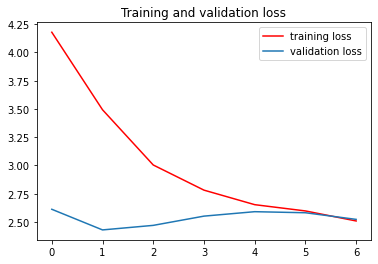

In [20]:
# Retrieve a list of list results on training and test data sets for each training epoch
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(loss))
# Plot training and validation loss per epoch
plt.plot(epochs,loss, color='red' , label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title ('Training and validation loss')

### Test the model by visualizing

### Test on a real image

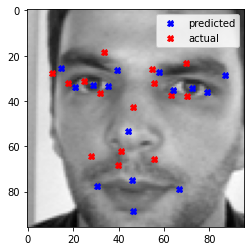

In [21]:
# test on an image from the validation set
batch = val_generator.__getitem__(0)
j= np.random.randint(0,len(batch[0]))

actual_features = batch[1][j:j+1][0]
image = batch[0][j:j+1]

predicted = my_model.predict(image)
       
predictions=[]
actuals=[]
if config.NORMALIZE_COORDINATES:
    actuals = scaler.inverse_transform([actual_features])[0]
    predictions = scaler.inverse_transform(predicted)[0]
    
visualize_image(image.reshape(96,96,3)[:,:,0],actuals,"images/prediction_example.png",predictions)

In [22]:
SIZE = 96
def get_prediction(image_path, scaler, rgb_channels, normalize_image, normalize_coordinates):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(SIZE, SIZE), color_mode="grayscale") #rgb
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0) #Convert single image to a batch.
    image = pre_process_image(image, rgb_channels, normalize_image)
    predicted = my_model.predict(image)
    if normalize_coordinates:
        predictions = scaler.inverse_transform(predicted)[0]
    visualize_image(image.reshape(96,96,3)[:,:,0], predictions,"images/prediction_example.png")
#     return predicted, predictions

def get_prediction2(image, scaler, rgb_channels, normalize_image, normalize_coordinates):
    image = pre_process_image(image, rgb_channels, normalize_image)
    predicted = my_model.predict(image)
    if normalize_coordinates:
        predictions = scaler.inverse_transform(predicted)[0]
    visualize_image(image.reshape(96,96,3)[:,:,0], predictions,"images/prediction_example.png") 
#     return predicted, predictions


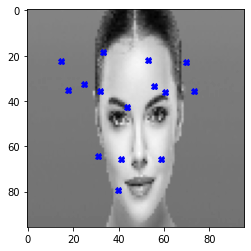

In [23]:
get_prediction("images/test1.jpeg", scaler, config.RGB_CHANNELS, config.NORMALIZE_IMAGE, config.NORMALIZE_COORDINATES)